In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import init_printing, symbols
from sympy.matrices import Matrix
init_printing(use_unicode=True)

In [2]:
h, a, b, c, d, e, f, T, V, W = symbols("h, a, b, c, d, e, f, T, V, W")

In [3]:
A = Matrix([[T+h*T+a*V+b*W],[W],[c*V+d*e**(-(T-10)**2/f)]])

In [4]:
A

In [ ]:
b = Matrix([0,0,0])

In [ ]:
A.solve(b)

[0]

# Graphs

- $\frac{dT}{dt} = T + h * T + a \cdot log(V) + b \cdot log(W) = h \cdot T + \log(V^a \cdot W^b)$
- $\frac{dW}{dt} = W$
- $\frac{dV}{dt} = a*\mathbb{E}(V)+b*e^{(-\frac{(T-\mathbb{E}(T)*d)^2}{c})}$

In [4]:
t_max = 50
t_min= 20
t_crit = 40comp_ecology/notebooks
h = 0.1
W = 0.5
p = 0.1

In [5]:
data = pd.read_csv("../data/water_green_area_temp.csv")
data = data[data["country"] == "Germany"]
data = data.pivot(columns=["variable"], values=["value"],index="city").reset_index()
data.columns = ["city", "V", "T", "W"]
data

,city,V,T,W
0,Berlin,906.291723,9.862667,1.261865e+09
1,Bonn,86.508465,10.426283,7.134201e+07
2,Bremen,1460.109486,10.002817,3.915588e+08
3,Dresden,430.819578,9.114751,2.260791e+08
4,Frankfurt,253.724771,10.466158,1.514076e+08
5,Hamburg,2750.633633,9.656578,3.120128e+09
6,Köln,135.449316,10.670819,9.259949e+07
7,Leipzig,304.171333,9.994178,1.948753e+08
8,München,1601.137142,9.412584,2.351916e+09
9,Nürnberg,792.518412,9.380152,5.313243e+07


## Vegetation vs Temp

[167.70632504  -0.29022905 -81.29239047]


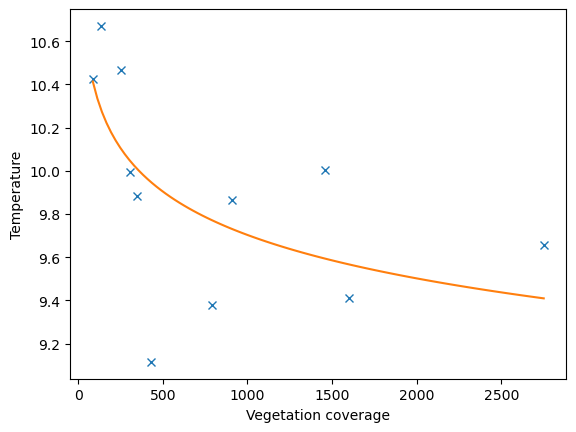

In [6]:
# Function candidates
def dt(V, h, a, b):
    T = data["T"].mean()
    W = data["W"].mean()
    return T + h * T + a * np.log(V) + b * np.log(W)

# Perform the curve fitting
popt, pcov = curve_fit(dt, data["V"], data["T"])

x_fit = np.linspace(min(data["V"]), max(data["V"]), 100)
y_fit = dt(x_fit, *popt)

plt.plot(data["V"],data["T"],"x")
plt.plot(x_fit,y_fit)
plt.ylabel("Temperature")
plt.xlabel("Vegetation coverage")
print(popt)

## Water vs Temp

[ 4.87894551e+02 -7.18894426e+02 -9.47281626e-02]


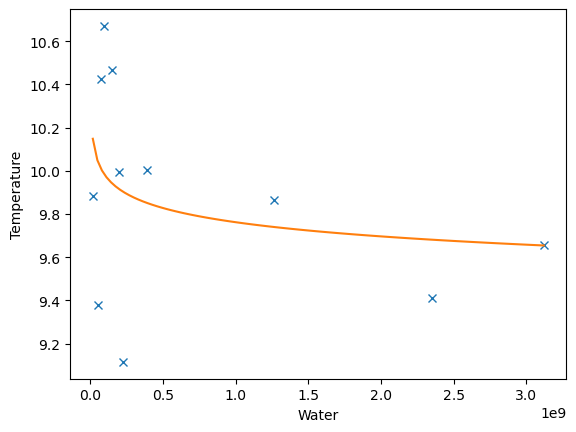

In [7]:
# Function candidates
def dt(W, h, a, b):
    T = data["T"].mean()
    V = data["V"].mean()
    return T + h * T + a * np.log(V) + b * np.log(W)

# Perform the curve fitting
popt, pcov = curve_fit(dt, data["W"], data["T"])

x_fit = np.linspace(min(data["W"]), max(data["W"]), 100)
y_fit = dt(x_fit, *popt)

plt.plot(data["W"],data["T"],"x")
plt.plot(x_fit,y_fit)
plt.ylabel("Temperature")
plt.xlabel("Water")
print(popt)

## Vegetation vs Temp

lin: [8.82837839e-01 7.20321533e+03]
log: [8.54160534e+00 1.61330726e+04]


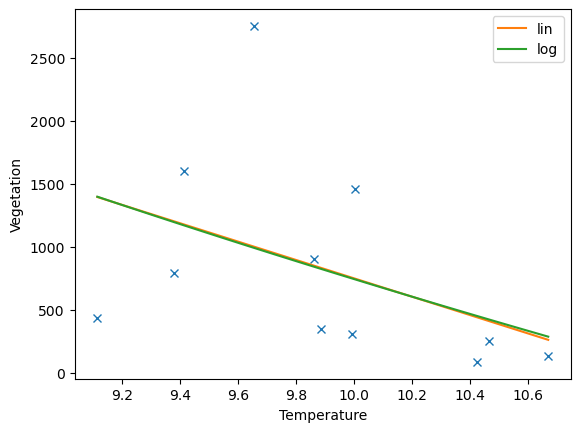

In [8]:
# Function candidates
def dV_lin(T, s, p):
    V = data["V"].mean()
    return V + p - s * T * V

def dV_log(T, s, p):
    V = data["V"].mean()
    return V + p - s * np.log(T) * V

# Perform the curve fitting
popt_lin, pcov_lin = curve_fit(dV_lin, data["T"], data["V"])
popt_log, pcov_log = curve_fit(dV_log, data["T"], data["V"])

x_fit = np.linspace(min(data["T"]), max(data["T"]), 100)
y_fit_lin = dV_lin(x_fit, *popt_lin)
y_fit_log = dV_log(x_fit, *popt_log)

plt.plot(data["T"],data["V"],"x")
plt.plot(x_fit,y_fit_lin, label="lin")
plt.plot(x_fit,y_fit_log, label="log")
plt.xlabel("Temperature")
plt.ylabel("Vegetation")
plt.legend(loc="best")
print("lin:",popt_lin)
print("log:",popt_log)

In [9]:
data

,city,V,T,W
0,Berlin,906.291723,9.862667,1.261865e+09
1,Bonn,86.508465,10.426283,7.134201e+07
2,Bremen,1460.109486,10.002817,3.915588e+08
3,Dresden,430.819578,9.114751,2.260791e+08
4,Frankfurt,253.724771,10.466158,1.514076e+08
5,Hamburg,2750.633633,9.656578,3.120128e+09
6,Köln,135.449316,10.670819,9.259949e+07
7,Leipzig,304.171333,9.994178,1.948753e+08
8,München,1601.137142,9.412584,2.351916e+09
9,Nürnberg,792.518412,9.380152,5.313243e+07


In [10]:
data["V"].mean()

824.3672681442423

[4.88491683e-01 2.61605976e+03 3.45681366e-02 9.69686655e-01]
lin: [4.88491683e-01 2.61605976e+03 3.45681366e-02 9.69686655e-01]


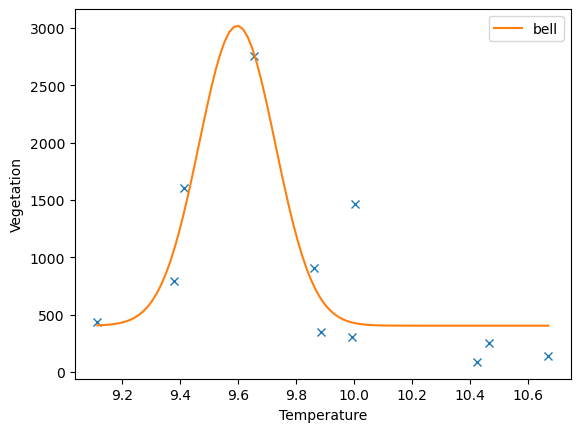

In [11]:
# Function candidates
def dV_bell(T, a, b, c, d):
    mean_temp = data["T"].mean()
    mean_v = data["V"].mean()
    return a*mean_v+b*np.exp(-((T - mean_temp*d)**2)/c)

# Perform the curve fitting
popt_bell, pcov_bell = curve_fit(dV_bell, data["T"], data["V"], bounds=([-np.inf,-np.inf, -np.inf, -1], [np.inf, np.inf, np.inf, 1]),
                                p0 =[1, 1000, 1, 1])

x_fit = np.linspace(min(data["T"]), max(data["T"]), 100)
y_fit_bell = dV_bell(x_fit, *popt_bell)

plt.plot(data["T"],data["V"],"x")
plt.plot(x_fit,y_fit_bell, label="bell")
plt.xlabel("Temperature")
plt.ylabel("Vegetation")
plt.legend(loc="best")
print("bell:",popt_bell)